# Building NARX Neural Network using Sysidentpy

Example created by Wilson Rocha Lacerda Junior

## Series-Parallen Training and Parallel prediction

Currently *SysIdentPy* support a Series-Parallel (open-loop) Feedforward Network training
process, which make the training process easier. We convert the NARX network from Series-Parallel to the Parallel (closed-loop) configuration for prediction. 

Series-Parallel allows us to use Pytorch directly for training, so we can use all the power of the Pytorch library to build our NARX Neural Network model! 

![](figures/narxnet.png)

The reader is referred to the following paper for a more in depth discussion about Series-Parallel and Parallel configurations regarding NARX neural network:

[Parallel Training Considered Harmful?: Comparing series-parallel and parallel feedforward
network training](https://arxiv.org/pdf/1706.07119.pdf)


## Building a NARX Neural Network

First, just import the necessary packages

In [ ]:
pip install sysidentpy

In [1]:
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

## Getting the data

The data is generated by simulating the following model:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-1} + e_{k}$.

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$,

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma=0.1$

In [2]:
x_train, x_valid, y_train, y_valid = get_siso_data(n=1000,
                                                   colored_noise=False,
                                                   sigma=0.01,
                                                   train_percentage=80)

## Choosing the NARX parameters, loss function and optmizer

One can create a NARXNN object and choose the maximum lag of both input and output for building the regressor matrix to serve as input of the network.

In addition, you can choose the loss function, the optmizer, the optinional parameters of the optmizer, the number of epochs.

Because we built this feature on top of Pytorch, you can choose any of the loss function of the torch.nn.functional. [Click here](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) for a list of the loss functions you can use. You just need to pass the name of the loss function you want.

Similarly, you can choose any of the optimizers of the torch.optim. [Click here](https://pytorch.org/docs/stable/optim.html) for a list of optimizers available.



In [3]:
narx_net = NARXNN(ylag=2,
                  xlag=2,
                  loss_func='mse_loss',
                  optimizer='Adam',
                  epochs=200,
                  verbose=True,
                  optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:27: FutureWarning: Function __init__ has been deprecated since v0.1.7.
 Use NARXNN(ylag=2, xlag=2, basis_function='Some basis function') instead.This module was deprecated in favor of NARXNN(ylag=2, xlag=2, basis_function='Some basis function') module into which all the refactored classes and functions are moved.
 This feature will be removed in version v0.2.0.
  warnings.warn(message, FutureWarning)


Since we have defined our NARXNN using $ylag=2$ and $xlag=2$, we have a regressor matrix with 4 features. We need the size of the regressor matrix to build the layers of our network. Our input data(x_train) have only one feature, but since we are creating an NARX network, a regressor matrix is built behind the scenes with new features based on the xlag and ylag. 

You can check the size the of the regressor matrix by using the following line of code:

In [4]:
len(narx_net.regressor_code) # the number of features of the NARX net

4

## Building the NARX Neural Network

The configuration of your network follows exactly the same pattern of a network defined in Pytorch. The following representing our NARX neural network.

In [5]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

We have to pass the defined network to our NARXNN estimator.

In [6]:
narx_net.net = NARX() 

## Numpy array to Tensor

If your inputs are numpy array, you can transform them to tensor using our *data_transform* method. Our function return a Dataloader object that we use to iterate on our training function. You can transform your inputs mannualy using TensorDataset and Dataloader using Pytorch.

Since our inputs are numpy arrays, we transform them using the following:

In [7]:
train_dl = narx_net.data_transform(x_train, y_train)
valid_dl = narx_net.data_transform(x_valid, y_valid)

## Fit and Predict

Because we have a fit (for training) and predict function for Polynomial NARMAX, we create the same pattern for the NARX net. So, you only have to fit and predict using the following:

In [8]:
narx_net.fit(train_dl, valid_dl)
yhat = narx_net.predict(x_valid, y_valid)

10-14 20:48:51 - INFO - Train metrics: 0.04131108850595497 | Validation metrics: 0.04906847903674299
10-14 20:48:51 - INFO - Train metrics: 0.028460200656588216 | Validation metrics: 0.03361141151099494
10-14 20:48:51 - INFO - Train metrics: 0.003378246061825999 | Validation metrics: 0.0031020104381810835
10-14 20:48:51 - INFO - Train metrics: 0.0079599755015551 | Validation metrics: 0.008645726645346543
10-14 20:48:51 - INFO - Train metrics: 0.0030233150559307114 | Validation metrics: 0.0029042966809650563
10-14 20:48:51 - INFO - Train metrics: 0.002685692424496127 | Validation metrics: 0.0023653891920629474
10-14 20:48:52 - INFO - Train metrics: 0.0024652570710146336 | Validation metrics: 0.002304245895386269
10-14 20:48:52 - INFO - Train metrics: 0.0019370706455506628 | Validation metrics: 0.0017436911620086794
10-14 20:48:52 - INFO - Train metrics: 0.0018388286208439815 | Validation metrics: 0.0016496724818334586
10-14 20:48:52 - INFO - Train metrics: 0.0017072744968050816 | Valida

0.00020776957378755621


c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:27: FutureWarning: Function residuals has been deprecated since v0.1.7.
 Use from sysidentpy.residues_correlation import compute_cross_correlation, compute_residues_autocorrelation instead.This module was deprecated in favor of from sysidentpy.residues_correlation import compute_cross_correlation, compute_residues_autocorrelation module into which all the refactored classes and functions are moved.
 This feature will be removed in version v0.2.0.
  warnings.warn(message, FutureWarning)


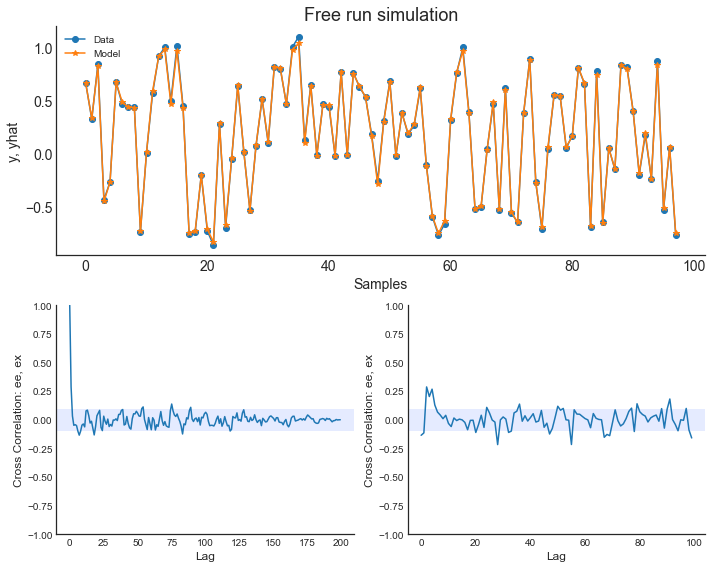

In [9]:
print(mean_squared_error(y_valid, yhat))

ee, ex, extras, lam = narx_net.residuals(x_valid, y_valid, yhat)
narx_net.plot_result(y_valid, yhat, ee, ex)

## Note

If you built the net configuration before calling the NARXNN, you can just pass the model to the NARXNN as follows:

10-14 20:49:00 - INFO - Train metrics: 0.13531316816806793 | Validation metrics: 0.13191769166727257
10-14 20:49:00 - INFO - Train metrics: 0.018423788828359808 | Validation metrics: 0.02039402553981001
10-14 20:49:00 - INFO - Train metrics: 0.017191101547171895 | Validation metrics: 0.018505071637907412
10-14 20:49:00 - INFO - Train metrics: 0.004398609300314409 | Validation metrics: 0.004448795477116499
10-14 20:49:00 - INFO - Train metrics: 0.005147629867968404 | Validation metrics: 0.0053938134347624855
10-14 20:49:00 - INFO - Train metrics: 0.0015457770559600646 | Validation metrics: 0.0018605957868405515
10-14 20:49:00 - INFO - Train metrics: 0.00198836172761671 | Validation metrics: 0.0024948635049201924
10-14 20:49:00 - INFO - Train metrics: 0.0012973400054879971 | Validation metrics: 0.001802109771013034
10-14 20:49:00 - INFO - Train metrics: 0.0012088184395774657 | Validation metrics: 0.0014578327865838402
10-14 20:49:00 - INFO - Train metrics: 0.0011429692711039238 | Validat

c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:27: FutureWarning: Function __init__ has been deprecated since v0.1.7.
 Use NARXNN(ylag=2, xlag=2, basis_function='Some basis function') instead.This module was deprecated in favor of NARXNN(ylag=2, xlag=2, basis_function='Some basis function') module into which all the refactored classes and functions are moved.
 This feature will be removed in version v0.2.0.
  warnings.warn(message, FutureWarning)


10-14 20:49:00 - INFO - Train metrics: 0.0009113025726379364 | Validation metrics: 0.001130729026485686
10-14 20:49:00 - INFO - Train metrics: 0.0008734577102878395 | Validation metrics: 0.0010684542469633273
10-14 20:49:00 - INFO - Train metrics: 0.0008441428745802688 | Validation metrics: 0.0010228202410155172
10-14 20:49:00 - INFO - Train metrics: 0.0008112886174521257 | Validation metrics: 0.0009746597615315231
10-14 20:49:00 - INFO - Train metrics: 0.0007797167214849745 | Validation metrics: 0.0009258962189308321
10-14 20:49:00 - INFO - Train metrics: 0.0007527490781928252 | Validation metrics: 0.0008886476309565508
10-14 20:49:00 - INFO - Train metrics: 0.0007271181716452958 | Validation metrics: 0.0008498650312310818
10-14 20:49:00 - INFO - Train metrics: 0.000702367844596916 | Validation metrics: 0.0008135927162565893
10-14 20:49:00 - INFO - Train metrics: 0.0006788028630236617 | Validation metrics: 0.0007808110018194925
10-14 20:49:00 - INFO - Train metrics: 0.0006567008202816

c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:27: FutureWarning: Function residuals has been deprecated since v0.1.7.
 Use from sysidentpy.residues_correlation import compute_cross_correlation, compute_residues_autocorrelation instead.This module was deprecated in favor of from sysidentpy.residues_correlation import compute_cross_correlation, compute_residues_autocorrelation module into which all the refactored classes and functions are moved.
 This feature will be removed in version v0.2.0.
  warnings.warn(message, FutureWarning)


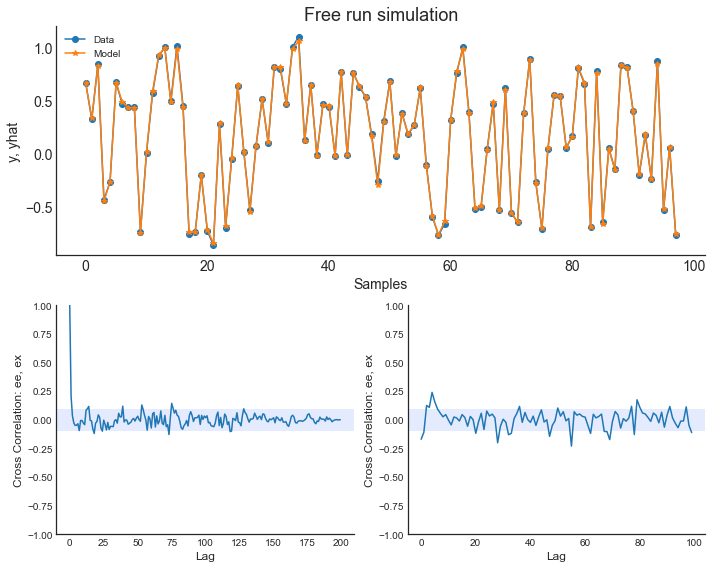

In [10]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

narx_net2 = NARXNN(net=NARX(),
                   ylag=2,
                   xlag=2,
                   loss_func='mse_loss',
                   optimizer='Adam',
                   epochs=200,
                   verbose=True,
                   optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

narx_net2.fit(train_dl, valid_dl)
yhat = narx_net2.predict(x_valid, y_valid)

ee, ex, extras, lam = narx_net2.residuals(x_valid, y_valid, yhat)
narx_net2.plot_result(y_valid, yhat, ee, ex)